In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2023-12-03 16:41:18.310566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 3

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2023-12-03 16:41:22.777335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-03 16:41:22.778442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


2023-12-03 16:41:24.131512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-03 16:41:24.304692: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


3/3 [==============================] - ETA: 0s - loss: 1.7520 - accuracy: 0.2918
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5


2023-12-03 16:41:25.871424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 349ms/step - loss: 1.7520 - accuracy: 0.2918 - val_loss: 1.2977 - val_accuracy: 0.2542
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.5300 - accuracy: 0.3125
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 0s 59ms/step - loss: 1.6982 - accuracy: 0.2521 - val_loss: 1.2352 - val_accuracy: 0.2458
Epoch 3/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.5289 - accuracy: 0.3047
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 0s 59ms/step - loss: 1.5266 - accuracy: 0.3088 - val_loss: 1.1779 - val_accuracy: 0.2119
Epoch 4/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.6473 - accuracy: 0.2266
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 0s 53ms/step - loss: 1.5457 - accuracy: 0.2635 - val_loss: 1.1263 

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 43ms/step - loss: 0.0451 - accuracy: 1.0000


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 189ms/step
[0.9025692  0.06073475 0.03669616]
0


2023-12-03 16:42:38.131544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# 混同行列

4/4 [==============================] - 0s 10ms/step


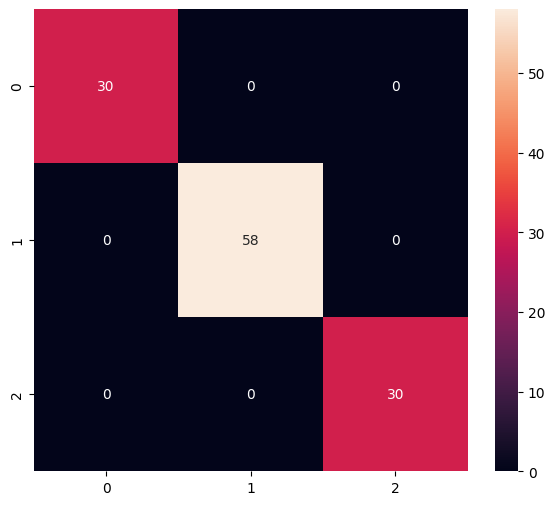

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        30

    accuracy                           1.00       118
   macro avg       1.00      1.00      1.00       118
weighted avg       1.00      1.00      1.00       118



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2023-12-03 16:42:39.575818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,42]
	 [[{{node input_1}}]]
2023-12-03 16:42:39.662957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2023-12-03 16:42:39.685689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,42]
	 [[{{node input_1}}]]
2023-12-03 16:4

INFO:tensorflow:Assets written to: /var/folders/gg/swd8dh_d3l12lvw08z_4b46m0000gn/T/tmp3bk7wtmg/assets


INFO:tensorflow:Assets written to: /var/folders/gg/swd8dh_d3l12lvw08z_4b46m0000gn/T/tmp3bk7wtmg/assets
2023-12-03 16:42:44.439804: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-03 16:42:44.439838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-03 16:42:44.441686: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gg/swd8dh_d3l12lvw08z_4b46m0000gn/T/tmp3bk7wtmg
2023-12-03 16:42:44.443678: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-12-03 16:42:44.443695: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/gg/swd8dh_d3l12lvw08z_4b46m0000gn/T/tmp3bk7wtmg
2023-12-03 16:42:44.454948: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-12-03 16:42:44.543247: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

6500

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 330 µs, sys: 261 µs, total: 591 µs
Wall time: 539 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.060952e-09 1.000000e+00 1.595966e-16]
1
